In [1]:
import time
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig
import os
import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy.stats import skew 
from scipy.stats import kurtosis 

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
     average_precision_score, confusion_matrix, accuracy_score, classification_report
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib
#import shap

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier

import mne
#from mne_connectivity import spectral_connectivity_epochs

import pandas as pd
from scipy.stats import ttest_1samp
from scipy.stats import chisquare

from scipy.stats import ttest_ind
import ast


from sklearn.metrics import mean_squared_error


2025-04-07 14:38:01.006327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# create and save feature arrays in subject folder
- ensure 64 trials for all subjects
- mean eeg, across trial, all trial
- output which files don't have 64 trials 
- count subjects

In [2]:
import sys
sys.path.insert(0,'/projectnb/ace-ig/deeksha/march25/')

## compute PSD

In [6]:
ace_pheno = pd.read_csv("/projectnb/ace-ig/ace_phenotype.csv")
ace_pheno.keys()

Index(['Site ID', 'GUID', 'New ID', 'Bioidentifier ID', 'site', 'race',
       'ethnic group', 'Biological Mother's income',
       'Biological Father's income', 'Household Income',
       ...
       'Somatic Problems', 'Conduct Problems',
       'Pubertal Development Scale Total',
       'Pubertal Development Scale Total.1', 'Unnamed: 142',
       'Social Affect Total', 'Behavioral Total.1', 'ADOS Total',
       'Comparison Score', 'ADOS Version.1'],
      dtype='object', length=148)

In [12]:
ace_pheno['Total T Score'][:3]

0    999
1    999
2    999
Name: Total T Score, dtype: int64

In [26]:
ace_pheno = pd.read_csv("/projectnb/ace-ig/ace_phenotype.csv")
ace_pheno['ID'] = ace_pheno['Site ID'].str[3:]

def get_PSD(trials64_eeg, filename, fs=512):
    freq, psd = sig.welch(trials64_eeg, fs, window='hamming',nperseg=512, noverlap=256)

    name_parts = filename.split(".")[:2]
    family, member_num = name_parts
    member_num = member_num[:2]
    ID = family+member_num
    diagnosis = ace_pheno.loc[ace_pheno['ID']==ID, 'Cohort'].values[0]
    diagnosis  = 1 if diagnosis == "ASD" else 0 if diagnosis == "CON" else None
    
    sex = ace_pheno.loc[ace_pheno['ID']==ID, 'Gender'].values[0]
    
    sex  = 1 if sex == "M" else 0 if sex == "F" else None
    
    guid= ace_pheno.loc[ace_pheno['ID']==ID, 'GUID'].values[0]
    interview_age= ace_pheno.loc[ace_pheno['ID']==ID, 'Interview Age (months)'].values[0]
    site = ace_pheno.loc[ace_pheno['ID']==ID, 'site'].values[0]
    srsT= ace_pheno.loc[ace_pheno['ID']==ID, 'Total T Score'].values[0]
    sens_adol  = ace_pheno.loc[ace_pheno['ID']==ID, 'SCQ Total'].values[0]
    if sens_adol == '25; 22':
        sens_adol = 25
    return freq, psd, diagnosis, sex, guid, interview_age,  site, srsT, sens_adol


In [27]:
root = "/projectnb/ace-ig/deeksha/day-2/processed/"

PSDs = np.zeros((190, 64, 129, 257))
freqs = np.zeros((190, 257))
trial_mean_PSDs = np.zeros((190, 129, 257))
trial_mean_freqs = np.zeros((190, 257))

diagnoses = np.zeros(190)
sexs = np.zeros(190)
guids= []
ages= np.zeros(190)
sites= []
all_srsT= np.zeros(190)
sens_adols= np.zeros(190)

i = 0
for filename in os.listdir(root):
    raw = mne.io.read_epochs_eeglab(root+filename)
    full_eeg = raw.get_data()
    if full_eeg.shape[0]<64:
        print('---------------------------\n', filename)
        # break
        continue
    trials_64_eeg = full_eeg[:64]
    #freq, psd, diagnosis, sex = get_PSD(trials_64_eeg, filename, fs=500)
    trial_mean_freq, trial_mean_psd, diagnosis, sex,guid, interview_age,  site, srsT, sens_adol = get_PSD(trials_64_eeg.mean(0), filename, fs=500)

    #PSDs[i]=psd
    trial_mean_PSDs[i]=trial_mean_psd
    #freqs[i] = freq
    trial_mean_freqs[i] = trial_mean_freq
    diagnoses[i] = diagnosis
    sexs[i] = sex
    guids.append(guid)
    ages[i] = interview_age
    sites.append(site)
    all_srsT[i] = srsT
    sens_adols[i] = sens_adol

    i+=1
sites = np.array(sites)  
guids = np.array(guids)

Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/780.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/755.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/713.03_processed.set...
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/735.03_processed.set...
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /projectnb/ace-ig/deeksha/day-2/processed/514.03_processed.set...
Not setting metadata
96 matching events found
No baseline correction applied
0 p

In [28]:
np.save("/projectnb/ace-ig/deeksha/march25/input_arrays/GUIDs.npy", guids)
np.save("/projectnb/ace-ig/deeksha/march25/input_arrays/interview_ages.npy", ages)
np.save("/projectnb/ace-ig/deeksha/march25/input_arrays/sens_adol.npy", sens_adols)
np.save("/projectnb/ace-ig/deeksha/march25/input_arrays/all_srsT.npy", all_srsT)
np.save("/projectnb/ace-ig/deeksha/march25/input_arrays/sites.npy", sites)
np.save("/projectnb/ace-ig/deeksha/march25/input_arrays/sexs.npy", sexs)

In [11]:
np.save('/projectnb/ace-ig/deeksha/march25/input_arrays/PSDs', PSDs) #all trial PSDs
np.save('/projectnb/ace-ig/deeksha/march25/input_arrays/freqs', freqs) 
np.save('/projectnb/ace-ig/deeksha/march25/input_arrays/trial_mean_PSDs', trial_mean_PSDs) #mean trial PSD
np.save('/projectnb/ace-ig/deeksha/march25/input_arrays/trial_mean_freqs', trial_mean_freqs)

np.save('/projectnb/ace-ig/deeksha/march25/input_arrays/diagnoses', diagnoses)

In [12]:
for i in range(190):
    if trial_mean_PSDs[i].max() == trial_mean_PSDs[i].min() == 0:
        print(0, i)
    if PSDs[i].max() == PSDs[i].min() == 0:
        print(1, i)
    

## extract final feature sets


In [16]:
PSDs = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/PSDs.npy')
PSDs = PSDs[:, :, :128, :] #remove base electrode
freqs = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/freqs.npy')
TM_PSDs = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/trial_mean_PSDs.npy') #trial_mean_PSDs
TM_PSDs = TM_PSDs[:, :128, :]
TM_freqs = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/trial_mean_freqs.npy')

In [17]:
mean = np.zeros((190, 64, 128, 5))
std = np.zeros((190, 64, 128, 5))
skew_ = np.zeros((190, 64, 128, 5))
kurtosis_ = np.zeros((190, 64, 128, 5))


for i in range(190):
    PSD = PSDs[i]
    freq = freqs[i]
    delta0 = len(freq[freq<=1]) 
    delta1 = len(freq[freq<4])
    theta0 = len(freq[freq<=4])
    theta1 = len(freq[freq<8])
    alpha0 = len(freq[freq<=8])
    alpha1 = len(freq[freq<13])
    beta0 = len(freq[freq<=13])
    beta1 = len(freq[freq<30])
    gamma0 = len(freq[freq<=30])
    gamma1 = len(freq[freq<=50])

    for j in range(5):
        slice_range = (0,0)
        if j == 0:
            slice_range = (delta0, delta1)
        elif j == 1:
            slice_range = (theta0, theta1)
        elif j == 2:
            slice_range = (alpha0, alpha1)
        elif j == 3:
            slice_range = (beta0, beta1)
        elif j == 4:
            slice_range = (gamma0, gamma1)
    
        sliced_psd = PSD[:, :, slice_range[0]:slice_range[1]]

        mean[i, :, :, j] = np.mean(sliced_psd, axis=-1)
        std[i, :, :, j] = np.std(sliced_psd, axis=-1)
        skew_[i, :, :, j] = skew(sliced_psd, axis=-1, bias=False)
        kurtosis_[i, :, :, j] = kurtosis(sliced_psd, axis=-1, fisher=True, bias=False)
        
PSD_features = np.zeros((4, 190, 64, 128, 5))
PSD_features[0, :, :, :, :] = mean
PSD_features[1, :, :, :, :] = std
PSD_features[2, :, :, :, :] = skew_
PSD_features[3, :, :, :, :] = kurtosis_


In [18]:
TM_mean = np.zeros((190, 128, 5))
TM_std = np.zeros((190, 128, 5))
TM_skew_ = np.zeros((190, 128, 5))
TM_kurtosis_ = np.zeros((190, 128, 5))


for i in range(190):
    PSD = TM_PSDs[i]
    freq = TM_freqs[i]
    delta0 = len(freq[freq<=1]) 
    delta1 = len(freq[freq<4])
    theta0 = len(freq[freq<=4])
    theta1 = len(freq[freq<8])
    alpha0 = len(freq[freq<=8])
    alpha1 = len(freq[freq<13])
    beta0 = len(freq[freq<=13])
    beta1 = len(freq[freq<30])
    gamma0 = len(freq[freq<=30])
    gamma1 = len(freq[freq<=50])

    for j in range(5):
        slice_range = (0,0)
        if j == 0:
            slice_range = (delta0, delta1)
        elif j == 1:
            slice_range = (theta0, theta1)
        elif j == 2:
            slice_range = (alpha0, alpha1)
        elif j == 3:
            slice_range = (beta0, beta1)
        elif j == 4:
            slice_range = (gamma0, gamma1)
    
        sliced_psd = PSD[:, slice_range[0]:slice_range[1]]

        TM_mean[i, :, j] = np.mean(sliced_psd, axis=-1)
        TM_std[i, :, j] = np.std(sliced_psd, axis=-1)
        TM_skew_[i, :, j] = skew(sliced_psd, axis=-1, bias=False)
        TM_kurtosis_[i, :, j] = kurtosis(sliced_psd, axis=-1, fisher=True, bias=False)
        
        
TM_PSD_features = np.zeros((4, 190, 128, 5))
TM_PSD_features[0, :, :, :] = TM_mean
TM_PSD_features[1, :, :, :] = TM_std
TM_PSD_features[2, :, :, :] = TM_skew_
TM_PSD_features[3, :, :, :] = TM_kurtosis_

In [20]:
acrtrials_PSD_features = np.zeros((2, 4, 190, 128, 5))
acrtrials_PSD_features[0, :, :, :, :,] = np.mean(PSD_features, axis=2)
acrtrials_PSD_features[1, :, :, :, :,] = np.std(PSD_features, axis=2)


print( PSD_features.shape, TM_PSD_features.shape, acrtrials_PSD_features.shape)

(4, 190, 64, 128, 5) (4, 190, 128, 5) (2, 4, 190, 128, 5)


In [21]:
np.save('/projectnb/ace-ig/deeksha/march25/input_arrays/64trial_PSDfeatures', PSD_features.transpose(1, 0, 2, 3, 4))
np.save('/projectnb/ace-ig/deeksha/march25/input_arrays/MeanEEG_PSDfeatures', TM_PSD_features.transpose(1,0,2,3))
np.save('/projectnb/ace-ig/deeksha/march25/input_arrays/AcrossTrial_PSDfeatures', acrtrials_PSD_features.transpose(2,0,1,3,4))

# TRAIN ML Models

In [2]:

def create_ann_model():
    
# FOR ACROSS-TRIAL
    model = Sequential()


    model.add(Dense(4096, input_shape=(x.shape[1],), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())

    # model.add(Dense(16, activation='relu'))
    # model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))


    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


ann_model = KerasClassifier(build_fn=create_ann_model, epochs=10, batch_size=32, verbose=1)


def plot_confusion_matrix(stats, labels, title):
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(stats[0], annot=True, fmt=".3f", cmap="Purples", xticklabels=labels, yticklabels=labels)
    
    for i in range(stats[0].shape[0]):
        for j in range(stats[1].shape[1]):
            text1= ax.text(j+0.5, i+0.6, f"±{stats[1][i, j]:.3f}", 
                    ha='center', va='center', color='red', fontsize=10)
#             text2 = ax.text(j+0.5, i+0.8, f"{percent_stats[0][i, j]:.3f}±{percent_stats[1][i, j]:.3f}%", 
#                     ha='center', va='center', color='limegreen', fontsize=10)
            

    plt.xlabel('Predicted diagnosis')
    plt.ylabel('True diagnosis')
    plt.title(title)
    plt.show()
    
def predict_ASD_shufflestrat_kfold(random_state, standardize_all, k, C, x, y, model, indices):
    kf = KFold(n_splits=k, shuffle=False) # indices controls shuffling
    
    if model == "RF":
        pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=random_state, bootstrap=False))
    elif model == "LR":
        pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=random_state))
    elif model == "SVC":
        pipeline = make_pipeline(StandardScaler(), SVC(random_state=random_state, probability=True))
    elif model == "ANN":
        pipeline = make_pipeline(StandardScaler(), ann_model)
    modelweights = []
        
    
    if standardize_all == False:
        pipeline = make_pipeline(RandomForestClassifier(random_state=random_state)) if model == "RF" else pipeline
        pipeline = make_pipeline(LogisticRegression(random_state=random_state)) if model == "LR" else pipeline
        pipeline = make_pipeline(SVC(random_state=random_state)) if model == "SVC" else pipeline
    
    all_scores = []
    all_confusion_matrices = []
    all_confusion_matrices_percent = []
    models = []
    
    f1_scores = []
    precisions = []
    recalls = []
    specificities = []
    aurocs = []
    auprcs = []
    dummyidx=5- len(indices)
    print(len(indices))
    for idx in indices:
        x_shuffled = x[idx]
        y_shuffled = y[idx]

        #scores = cross_val_score(pipeline, x_shuffled, y_shuffled, cv=kf, scoring='accuracy')
        #all_scores.append(scores)
        
        #y_pred = cross_val_predict(pipeline, x_shuffled, y_shuffled, cv=kf)
        labels = np.unique(y_shuffled)
        
        confusion_matrices = []
        confusion_matrices_percent = []

        for train_index, test_index in kf.split(x_shuffled, y_shuffled):
            x_train, x_test = x_shuffled[train_index], x_shuffled[test_index]
            y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]

            pipeline.fit(x_train, y_train)
            y_pred_fold = pipeline.predict(x_test)

            cm = confusion_matrix(y_test, y_pred_fold, labels=labels)
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            confusion_matrices.append(cm)
            confusion_matrices_percent.append(cm_percent)
            
            all_scores.append(accuracy_score(y_test, y_pred_fold))
            f1_scores.append(f1_score(y_test, y_pred_fold, average='binary'))
            precisions.append(precision_score(y_test, y_pred_fold, average='binary'))
            recalls.append(recall_score(y_test, y_pred_fold, average='binary'))

            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp)
            specificities.append(specificity)
            
            if len(np.unique(y_test)) > 1:  # Check if there is more than one class
                y_probs = pipeline.predict_proba(x_test)[:, 1]
                aurocs.append(roc_auc_score(y_test, y_probs))
                auprcs.append(average_precision_score(y_test, y_probs))
            
            if model == "RF":
                models.append(pipeline.named_steps['randomforestclassifier'])
            elif model == "LR":
                models.append(pipeline.named_steps['logisticregression'])
                modelweights.append(pipeline.named_steps['logisticregression'].coef_.flatten())

            #clear memory
        dummy = np.array([all_scores[-5:], f1_scores[-5:], precisions[-5:], recalls[-5:], specificities[-5:], aurocs[-5:], auprcs[-5:] ])
        dummyidx+=1
        np.save(f"resultsANN64_{dummyidx}.npy", dummy)
        print('\n\n ', dummyidx, ' done *************************************')
        
        all_confusion_matrices.append(confusion_matrices)
        all_confusion_matrices_percent.append(confusion_matrices_percent)
    
    scores_stats = (np.mean(all_scores), np.std(all_scores))
    confusion_matrices_stats = (np.mean([np.mean(cm, axis=0) for cm in all_confusion_matrices], axis=0), 
                                np.std([np.std(cm, axis=0) for cm in all_confusion_matrices], axis=0))
    percent_stats = (np.mean([np.mean(cm, axis=0) for cm in all_confusion_matrices_percent], axis=0), 
                     np.std([np.std(cm, axis=0) for cm in all_confusion_matrices_percent], axis=0))

    metrics_stats = {
        'accuracy': (np.mean(all_scores), np.std(all_scores)),
        'f1_score': (np.mean(f1_scores), np.std(f1_scores)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'specificity': (np.mean(specificities), np.std(specificities)),
        'auroc': (np.mean(aurocs), np.std(aurocs)),
        'auprc': (np.mean(auprcs), np.std(auprcs))
    }
    
    all_metrics = {
        'all_accuracy': all_scores,
        'all_f1_score': f1_scores,
        'all_precision': precisions,
        'all_recall': recalls,
        'all_specificity': specificities,
        'all_auroc': aurocs,
        'all_auprc': auprcs
    }
    
    metrics_stats = round_metrics_dict(metrics_stats, 3)

    return all_scores, scores_stats, confusion_matrices_stats, labels, percent_stats, metrics_stats, models, all_metrics, np.array(modelweights)

def round_metrics_dict(d, decimals=3):
        return {k: (round(v[0], decimals), round(v[1], decimals)) for k, v in d.items()}


In [4]:

tf.config.threading.set_intra_op_parallelism_threads(11)  # Intra-op parallelism
tf.config.threading.set_inter_op_parallelism_threads(11)  # Inter-op parallelism


In [5]:
print(tf.config.threading.get_inter_op_parallelism_threads())

11


In [21]:
len(indices[-1:])

1

(190, 4, 64, 128, 5)
(190, 163840)
(190,)
4
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5888 - loss: 0.7828
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7774 - loss: 0.4977
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8546 - loss: 0.3309
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8228 - loss: 0.3590
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8441 - loss: 0.3190
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9194 - loss: 0.2083
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9195 - loss: 0.1953
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9691 - loss: 0.1427
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9695 - loss: 0.1200
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9921 - loss: 0.0592
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.50

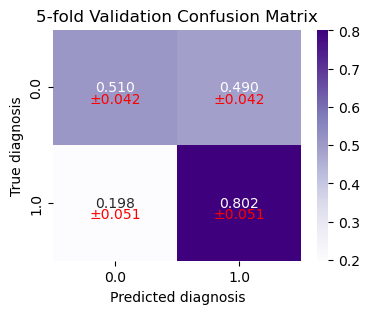

ACCURACY: 0.650±0.084


In [6]:
random_state=35
standardize_all=True
k=5
C=0.01
model = "ANN"
PSD_features = "64trial"

x = np.load(f"/projectnb/ace-ig/deeksha/march25/input_arrays/{PSD_features}_PSDfeatures.npy", allow_pickle=True)


print(x.shape)
x = x.reshape(190, -1)

print(x.shape)

y = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/diagnoses.npy', allow_pickle=True)

print(y.shape)

indices = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/5indices.npy',allow_pickle=True)

all_scores, scores_stats, confusion_matrices_stats, labels, percent_stats, metrics_stats, models, all_metrics, weights = predict_ASD_shufflestrat_kfold(random_state,standardize_all,k,C,x,y,model, indices)


plot_confusion_matrix(percent_stats, labels, f"{k}-fold Validation Confusion Matrix")
print(f"ACCURACY: {scores_stats[0]:.3f}±{scores_stats[1]:.3f}")

In [18]:
#np.save(f"/projectnb/ace-ig/deeksha/march25/results/{model}_{PSD_features}_weights.npy", weights)

#Save to a file
with open(f"/projectnb/ace-ig/deeksha/march25/results/{model}_{PSD_features}_results.pkl", 'wb') as file:
   pickle.dump(all_metrics, file)


# with open('{model}_{PSD_featuers}_results.pkl', 'rb') as file:
#     loaded_dict = pickle.load(file)

In [12]:
PSD_features, model

('64trial', 'ANN')

# Load and print table

In [27]:
from scipy.stats import ttest_ind_from_stats

In [39]:
for model in ['LR', 'RF', 'SVC', 'ANN']:
    accuracies, f1scores, aurocs, auprcs = [],[],[],[]
    for PSD_features in ['AcrossTrial', '64trial', 'MeanEEG']:
        
        with open(f"/projectnb/ace-ig/deeksha/march25/results/{model}_{PSD_features}_results.pkl", 'rb') as file:
            loaded_dict = pickle.load(file)
        file.close()

        try:
            acc = np.concatenate(loaded_dict['all_accuracy'])
        except:
            acc = np.array(loaded_dict['all_accuracy'])
        
        f1  = np.array(loaded_dict['all_f1_score'])
        prec = np.array(loaded_dict['all_precision']) 
        rec  = np.array(loaded_dict['all_recall']) 
        spec = np.array(loaded_dict['all_specificity'])
        auroc = np.array(loaded_dict['all_auroc'])
        auprc =  np.array(loaded_dict['all_auprc']) 

        accuracies.append((acc.mean(), acc.std()))
        f1scores.append((f1.mean(), f1.std()))
        aurocs.append((auroc.mean(), auroc.std()))
        auprcs.append((auprc.mean(), auprc.std()))
                
        #print(f"{acc.mean():.3f}$\pm${acc.std():.3f}&{f1.mean():.3f}$\pm${f1.std():.3f}&{prec.mean():.3f}$\pm${prec.std():.3f}&{rec.mean():.3f}$\pm${rec.std():.3f}&{spec.mean():.3f}$\pm${spec.std():.3f}&{auroc.mean():.3f}$\pm${auroc.std():.3f}&{auprc.mean():.3f}$\pm${auprc.std():.3f}")
    
    # Two-sided t-test
    t_stat, p_value1 = ttest_ind_from_stats(mean1=accuracies[0][0], std1=accuracies[0][1], nobs1=25,
                                       mean2=accuracies[1][0], std2=accuracies[1][1], nobs2=25,
                                       equal_var=False)  # Welch's t-test        
    t_stat, p_value2 = ttest_ind_from_stats(mean1=accuracies[0][0], std1=accuracies[0][1], nobs1=25,
                                       mean2=accuracies[2][0], std2=accuracies[2][1], nobs2=25,
                                       equal_var=False)  # Welch's t-test 
    print(np.round(p_value1, 3), np.round(p_value2, 3))
    t_stat, p_value1 = ttest_ind_from_stats(mean1=f1scores[0][0], std1=f1scores[0][1], nobs1=25,
                                       mean2=f1scores[1][0], std2=f1scores[1][1], nobs2=25,
                                       equal_var=False)  # Welch's t-test        
    t_stat, p_value2 = ttest_ind_from_stats(mean1=f1scores[0][0], std1=f1scores[0][1], nobs1=25,
                                       mean2=f1scores[2][0], std2=f1scores[2][1], nobs2=25,
                                       equal_var=False)  # Welch's t-test 
    print(np.round(p_value1, 3), np.round(p_value2, 3))
    t_stat, p_value1 = ttest_ind_from_stats(mean1=aurocs[0][0], std1=aurocs[0][1], nobs1=25,
                                       mean2=aurocs[1][0], std2=aurocs[1][1], nobs2=25,
                                       equal_var=False)  # Welch's t-test        
    t_stat, p_value2 = ttest_ind_from_stats(mean1=aurocs[0][0], std1=aurocs[0][1], nobs1=25,
                                       mean2=aurocs[2][0], std2=aurocs[2][1], nobs2=25,
                                       equal_var=False)  # Welch's t-test 
    print(np.round(p_value1, 3), np.round(p_value2, 3))
    t_stat, p_value1 = ttest_ind_from_stats(mean1=auprcs[0][0], std1=auprcs[0][1], nobs1=25,
                                       mean2=auprcs[1][0], std2=auprcs[1][1], nobs2=25,
                                       equal_var=False)  # Welch's t-test        
    t_stat, p_value2 = ttest_ind_from_stats(mean1=auprcs[0][0], std1=auprcs[0][1], nobs1=25,
                                       mean2=auprcs[2][0], std2=auprcs[2][1], nobs2=25,
                                       equal_var=False)  # Welch's t-test
    print(np.round(p_value1, 3), np.round(p_value2, 3))                                       

0.325 0.0
0.662 0.0
0.994 0.0
0.713 0.001
0.086 0.131
0.099 0.089
0.06 0.034
0.05 0.075
0.092 0.025
0.008 0.001
0.064 0.007
0.06 0.035
0.853 0.587
0.233 0.684
0.512 0.152
0.396 0.264


In [35]:
accuracies[0]

(0.671578947368421, 0.07105068223446824)

In [17]:
loaded_dict['all_auroc']

[0.7391304347826086,
 0.7174515235457064,
 0.7414772727272727,
 0.7728531855955678,
 0.6806722689075629,
 0.8138888888888889,
 0.8254847645429363,
 0.6444444444444444,
 0.8194444444444444,
 0.6974789915966386,
 0.7916666666666666,
 0.8403361344537815,
 0.7886904761904762,
 0.5983379501385042,
 0.7897727272727273,
 0.8115942028985508,
 0.7563025210084033,
 0.5944444444444446,
 0.8337950138504154,
 0.7871148459383754,
 0.8599439775910364,
 0.7839335180055401,
 0.7527777777777778,
 0.736231884057971,
 0.6144927536231884]